In [1]:
import numpy as np
import imageio
from matplotlib import pyplot as plt

In [ ]:
# TODOS:
# Split stereogram into smaller functions
# Is there a way to smooth out the levels? Averaging pixel values?
# Is there a way to control the resolution of pixel detail independently of the input image resolution?

In [55]:
# This box holds a function (a faster random-dot stereogram generator) using an inner function.
def stereogram(filename='saturn.png', maxshift=140, stripe=None, cmap=None, save_file=False, show=False):
    """Makes Autostereograms, also known as Magic-eye Illusions
    Note: Max depth and min depth are normalized"""
    # Image of overlay, with grayscale brightness being the depth.
    depth_map = imageio.imread(filename)
    uint8_max = 256 if np.issubdtype(depth_map.dtype, np.uint8) else None
    if len(depth_map.shape) == 4: #RGBA
        depth_map = np.mean(depth_map[:,:,:3], axis=2)
    elif len(depth_map.shape) == 3: #RGB
        depth_map = np.mean(depth_map, axis=2)
    he, wi = depth_map.shape

    # 1/6 total width is for far offset, 1/8 for near offset
    # They scale with depth map resolution
    far_wi, near_wi = wi // 6, wi // 8
    
    minshift = far_wi - near_wi
    if save_file or show:
        print(f'far width shift: {far_wi}, near width shift: {near_wi}, '
              f'diff: {minshift}, upper bound shift: {maxshift}')
    # Max pixel shift is not more than maxshift argument
    diff = np.min((minshift, maxshift))
    
    map_min, map_max = np.min(depth_map), np.max(depth_map)
    print(f'depth map min: {map_min}, depth map max: {map_max}')
    if uint8_max is not None:
        diff = diff*(map_max - map_min) / uint8_max
    # offset_map is array of image shape with integer values in [0, diff].
    offset_map = np.round(diff * ((depth_map - map_min) / (map_max - map_min))).astype(int)
    print(f'new min: {np.min(offset_map)}, new max: {np.max(offset_map)}')
    
    # n_cols is for figure size only
    m_rows, n_cols = he, wi + diff
    
    # Create Background starter with m_rows rows of color.
    if stripe is None:
#         barr = far_wi // diff
#         strip_width = far_wi - barr
        strip_width = far_wi
        background = np.random.uniform(0, 1, size=(m_rows, strip_width))
#         edges = np.round(np.random.rand(m_rows, barr)) / 2
#         background = np.append(background, edges, axis=1)
#         print('strip shape:', background.shape)
    else:
        strip = stripe[:,:,:3]
        dim = strip.shape
        j,k = dim[0], dim[1]
        # Width <= 140 is for good viewing.
#         far_wi = max((far_wi, k))
        repeat_rows = m_rows // j + 1
        repeat_cols = far_wi // k + 1
        # Grayscale must tile differently.
        if cmap is None:
            background = np.tile(strip, [repeat_rows, repeat_cols, 1])[:m_rows,:far_wi]
        else:
            strip = np.mean(strip, axis=2)
            background = np.tile(strip, [repeat_rows, repeat_cols])[:m_rows,:far_wi]
            
#     # Color Variance (bigger means larger shifts).
#     cvar = .1
#     roff = 0
#     rowsoff = [0,]
#     for _ in range(m_rows - 1):
#         roff += np.random.uniform(-1, 1) * cvar
#         rowsoff.append(roff)
#     background = (background + np.array(rowsoff).reshape((m_rows,1))) % 1

    # Generate the image, helper function
    #### not finished for (m_rows,n_cols,p) background
    def gen_rows(backg, off_map):
        if stripe is None:
            for i in range(wi):
                # col = background[ rows, cols ] # Fancy Indexing (i.e. specify wanted pixels).
                col = backg[np.arange(m_rows), i + off_map[:,i]].reshape((m_rows,1))
                backg = np.append(backg, col, axis=1)
        else:
            for i in range(wi):
                # col = background[ rows, cols ] # Fancy Indexing.
                if cmap is None:
                    col = backg[np.arange(m_rows), i + off_map[:,i]].reshape((m_rows,1,3))
                else:
                    col = backg[np.arange(m_rows), i + off_map[:,i]].reshape((m_rows,1))
                backg = np.append(backg, col, axis=1)
        return backg
    
    image = gen_rows(background, offset_map)
    
    if save_file:
        print('image shape:', image.shape)
        print('cmap:', cmap)
        mx = np.max(image)
        image = (image * 255 / mx).astype(np.uint8)
        i = filename.find('.')
        plt.imsave(filename[:i] + 'stereogram.png', image, cmap=cmap)

    if show:
        # Estimates a good figure size.
        fig_sz = int(max([10 * m_rows / n_cols, 13]))
        print('figure size:', fig_sz)
        print(f'cmap: {cmap}')
        fig = plt.figure(figsize=(fig_sz, fig_sz))
        plt.imshow(image, cmap=cmap)
        plt.axis("off")
        plt.show()
    
    # include ability to input a depth_map strip
    
    # output in color, random or like cmaps
    
    # make a mild structure to the strip, randomize 4/5 rows and every 5th has structure
    
    # half width and double the depth_map repetition so the construction is not visible

In [32]:
"""
Primary Color maps:
viridis, plasma, winter, copper, coolwarm, 
ocean, gist_earth, terrain, gist_stern, gnuplot, gnuplot2, CMRmap, 
cubehelix, gist_rainbow, rainbow, nipy_spectral, gist_ncar, 
flag, pink, PiYG, PRGn, BrBG, PuOr, RdGy, RdBu, RdYlBu, RdYlGn, Spectral, bwr
"""

cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis',
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn',
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper',
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic',
            'twilight', 'twilight_shifted', 'hsv',
#             'Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 
#             'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'flag', 'prism', 
            'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral',
            'gist_ncar']

In [33]:
"""
CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=72063
"""
stripe = imageio.imread('RidingTigersPattern.png')
# fig = plt.figure(figsize=(10,10))
# plt.imshow(stripe)
# plt.show()

far width shift: 104, near width shift: 78, diff: 26, upper bound shift: 50
depth map min: 0, depth map max: 142
new min: 0, new max: 14
figure size: 13
cmap: None


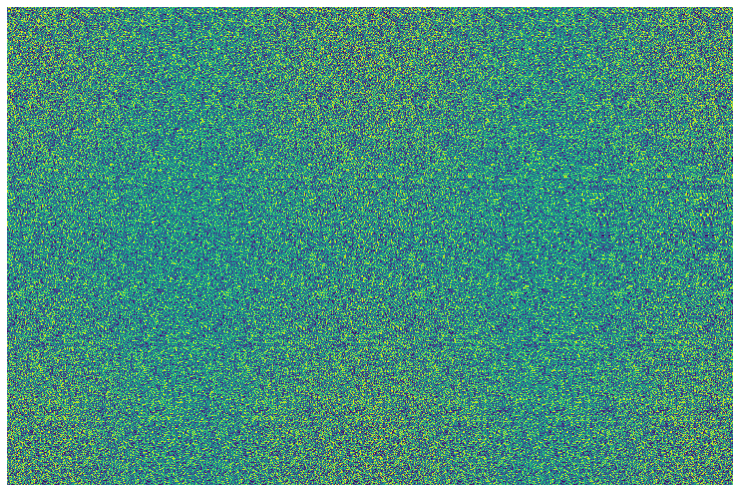

In [60]:
# This box will produce a stereogram.
# Type the name of the file for the depth map.
# Also type the name of the file for the stripe pattern. If None, it will produce a colormap.

# depth_map = 'globe.jpg'
depth_map = 'smiley1.png'
# stripe = 'RidingTigersPattern.png'
stripe = None

if stripe is not None:
    stripe = imageio.imread(stripe)

# To get the stereogram.
maxd = 50
# coloring = 'YlOrBr'
coloring = None
saving = False
showing = True

stereogram(depth_map, stripe=stripe, maxshift=maxd, cmap=coloring, save_file=saving, show=showing)
# for cmap in cmaps:
#     stereogram('saturn.png', maxshift=maxd, cmap=cmap, save_file=saving, show=showing)